In [125]:
import torch
import torch.functional as F
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torchviz import make_dot
from IPython.display import HTML
from tqdm import tqdm
from itertools import cycle
%matplotlib inline

In [2]:
# strength and range parameter of potential
eps,sig = 1.0,1.5

In [3]:
def Ulj(rs):
    f6 = (sig / rs) ** 6
    return 4*eps*(f6*f6  - f6)

In [4]:
base = torch.linspace(0.0, 4*sig,1000, requires_grad=True)
xs = base / sig
ps = Ulj(xs)/eps
loss = ps.sum()
loss.backward()
dps = base.grad / eps

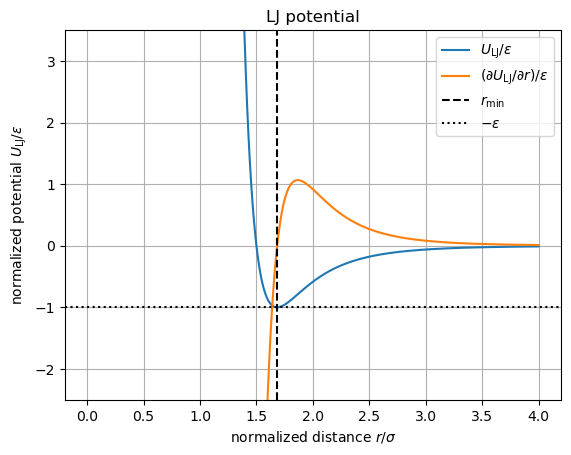

In [5]:
with torch.no_grad():
    plt.plot(xs,ps,label="$U_\\mathrm{LJ}/\\varepsilon$")
    plt.plot(xs,dps,label="$(\\partial U_\\mathrm{LJ}/\\partial r)/\\varepsilon$")
plt.ylim(-2.5,3.5)
plt.grid(True)
plt.title("LJ potential")
plt.xlabel("normalized distance $r/\\sigma$")
plt.ylabel("normalized potential $U_\\mathrm{LJ}/\\varepsilon$")
r_min = (2 ** (1/6)) * sig
plt.axvline(r_min, color="k", linestyle="--", label="$r_\\mathrm{min}$")
plt.axhline(-eps, color="k", linestyle=":", label="$-\\varepsilon$")
plt.legend()

### Calculating forces

Calculate the force between two particles at positions $r_1$ and $r_2$ like this: $\text{F}=-\frac{\partial U_\text{LJ}}{\partial r}$ where $r$ is the euclidean distance between the two particles.

In [250]:
dt = 1e-5
epochs, subepochs = 300, 750
total_epochs = epochs*subepochs
m = 1.0 # particle mass

In [251]:
# world specification
world_min, world_max = 3.5*torch.tensor([[-1.0,-1.0],[1.0,1.0]])

In [258]:
# define walls
def wall(line_start, line_end, nparts_wall=4):
    # TODO: make nparts_wall depend on line length and required density
    rs = torch.zeros((nparts_wall, 2))
    for idx in range(nparts_wall):
        t = idx / (nparts_wall - 1)
        rs[idx] = line_start + (line_end - line_start)*t
    return rs
static_rs = torch.cat((
    wall(*torch.tensor([[world_min[0],world_max[1]],[world_max[0],world_max[1]]])),
    wall(*torch.tensor([[world_min[0],world_min[1]],[world_max[0],world_min[1]]])),
    wall(*torch.tensor([[world_min[0],world_min[1]+2.25],[world_min[0],world_max[1]-2.25]]),2),
    wall(*torch.tensor([[world_max[0],world_min[1]+2.25],[world_max[0],world_max[1]-2.25]]),2),
))
static_vs = torch.zeros_like(static_rs)
static_rs.shape

torch.Size([12, 2])

In [259]:
# define movable particles
act_rs = torch.tensor([[-1.0,0.0],[1.0,0.0],[0.0,-1.0],[0.0,1.0]], requires_grad=True)
act_vs = torch.tensor([[5.0*sig,0.0],[-5.0*sig,0.0],[0.0,2.0*sig],[0.0,-2.0*sig]])

In [260]:
K = lambda v: 0.5*m*(F.norm(v, p=2.0, dim=1)**2)
with torch.no_grad():
    dists = F.norm(rs[None,:,:] - rs[:,None,:], dim=-1)
    Ks,Us = [K(act_vs).sum()], [Ulj(F.norm(dists, p=2.0)).item()]
    rs = torch.cat((act_rs,static_rs))
    vs = torch.cat((act_vs,static_vs))
    trajs = [(rs.clone(), vs.clone(), dists.clone())]

100%|███████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.31it/s]


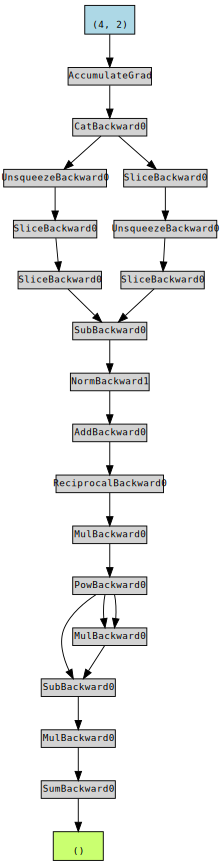

In [261]:
for epoch in tqdm(range(epochs)):
    for _ in range(subepochs):
        # collect all particles
        rs = torch.cat((act_rs,static_rs))
        
        # calculate potential
        dr = rs[None,:,:] - rs[:,None,:]
        dists = F.norm(dr, dim=-1)
        # set diagonal distance entries to inf to make potential 0
        dists = dists + torch.diag(torch.inf * torch.ones(len(rs)))
        pot = Ulj(dists)
        potsum = pot.sum()
        
        # clear gradients and calc derivative
        act_rs.grad = None
        potsum.backward()
        # update particles
        with torch.no_grad():
            pot_F = -act_rs.grad
            a = pot_F/m
            
            # TODO: velocity verlet
            act_vs += dt*a
            act_rs += dt*act_vs# + 0.5*a1*(dt**2)
    with torch.no_grad():
        trajs.append((rs.clone(),torch.cat((act_vs,static_vs)).clone(),dists.clone()))
        Ks.append(K(act_vs).sum())
        Us.append(potsum.item())
make_dot(potsum)

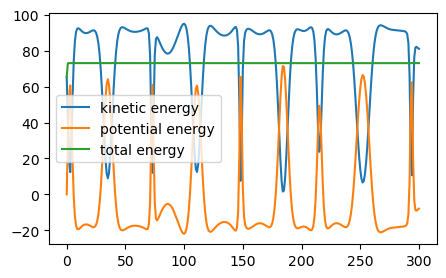

In [262]:
# show hockeystick diagram
fig,ax = plt.subplots(sharex=True,figsize=(5,3))
ax.plot(Ks, label="kinetic energy")
ax.plot(Us, label="potential energy")
ax.plot(torch.tensor(Ks)+torch.tensor(Us), label="total energy")
ax.legend()

100%|███████████████████████████████████████████████████████████████████████| 301/301 [00:05<00:00, 59.35it/s]


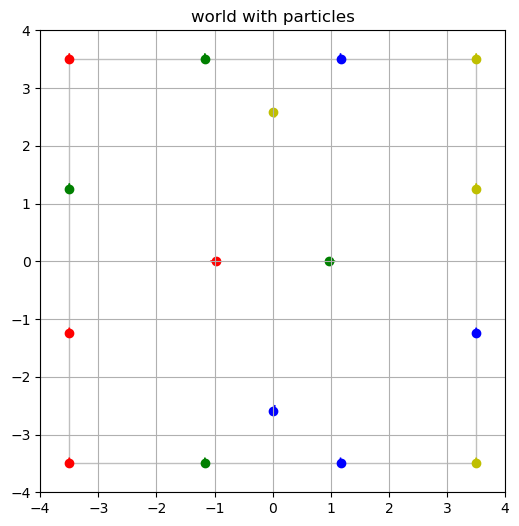

In [265]:
arrow_params = lambda c: dict(head_width=0.05, head_length=0.1, fc=c, ec=c, animated=True)

fig,ax = plt.subplots(figsize=(6,6))

# plot organization
ax.set_title("world with particles")
ax.grid(True)

# show virtual world borders
ax.set_xlim(world_min[0]-.5,world_max[0]+.5)
ax.set_ylim(world_min[1]-.5,world_max[1]+.5)
ax.add_patch(plt.Rectangle(world_min, *(world_max - world_min), fc="none", ec=".75"))

# store trajectory images
frames = []
for rs,vs,_ in tqdm(trajs):
    elems = []
    for i,(r,v,c) in enumerate(zip(rs, vs, cycle(list("rgby")))):
        elems += [
            ax.scatter(*r, label=f"p{i}", color=c, animated=True),
            ax.arrow(*r, *dt*v, label=f"p{i}'s speed vector", **arrow_params(c)),
        ]
    frames.append(elems)
ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True, repeat_delay=1500)
HTML(ani.to_html5_video())